In [1]:
# Create sagemaker model and run inference endpoint
import sagemaker, boto3, os
from sagemaker.huggingface.model import HuggingFaceModel

s3_path_to_models = "s3://miro-integration-ml-model-store"
my_model_name = "sd-12-custom-model-0001.tar.gz"

full_model_path = os.path.join(s3_path_to_models, my_model_name)

# prepare model execution role
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# create model
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=full_model_path,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.12",  # transformers version used
   pytorch_version="1.9",        # pytorch version used
   py_version='py38',            # python version used
)

print ("Model created: ", huggingface_model)

Model created:  <sagemaker.huggingface.model.HuggingFaceModel object at 0x7ff292f9b0a0>


In [2]:
%%time
# create inference endpoint
# deploy the endpoint endpoint
# Inference types: https://aws.amazon.com/sagemaker/pricing/
instance_type = "ml.p3.2xlarge"

predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type
    )

---------------!CPU times: user 334 ms, sys: 21.7 ms, total: 355 ms
Wall time: 8min 4s


In [3]:
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'huggingface-pytorch-inference-2023-05-14-08-02-14-528'

In [10]:
%%time
# Test image generation

data = {
    "prompt" : "a man riding horse on the island",
    
}

result = predictor.predict(data)

CPU times: user 41.5 ms, sys: 22 µs, total: 41.5 ms
Wall time: 4.39 s


In [4]:
result

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a\nHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIy\nMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAgADASIA\nAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQA\nAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3\nODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWm\np6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEA\nAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSEx\nBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElK\nU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3\nuLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDhKMUu\nKMUjcTFGKdilxQA2inYoxQA2lpce1GKAExRTsUYoATFGKdijFAhMUtLiimAlKKKXFAxRS0ClxQAU\ntGKKLgKKcKaKcKB2JB0pw600c1IvPUUxocAalK8A01Bj3p4ORVIY5T81Kv3TTRw

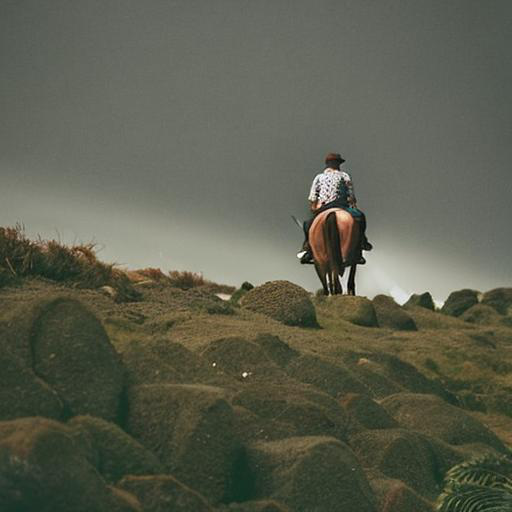

In [11]:
# Create image from result
from io import BytesIO
import base64
from PIL import Image

# What to do with string to make it bytes again
new_byte_io = BytesIO(base64.decodebytes(result.encode("utf-8")))

new_image = Image.open(new_byte_io)
new_image.show()

In [8]:

print("Received reply from endpoint, len: ", len(result))
response_image = result["Body"]
stream = response_image.read()
data = json.loads(stream)
image, prompt = data['generated_images'][0], data['prompt']
img_to_save = Image.fromarray(np.uint8(np.array(image)), "RGB")


Received reply from endpoint, len:  73779


TypeError: string indices must be integers

In [12]:
%%time
import json
ENDPOINT_NAME_MODIFY = "huggingface-pytorch-inference-2023-05-12-23-26-40-473"

runtime = boto3.client('runtime.sagemaker')
parameters = b'{    "action": "create", "prompt": "a man riding horse on the island"}'
#
print ("Call endpoint: ", ENDPOINT_NAME_MODIFY )
print ("With parameters: ", parameters)
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME_MODIFY,
                                   ContentType='application/json',
                                   Body=parameters)
print ("Received reply from endpoint, len: ", len(response))
# What to do with string to make it bytes again
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)

Call endpoint:  huggingface-pytorch-inference-2023-05-12-23-26-40-473
With parameters:  b'{    "action": "create", "prompt": "a man riding horse on the island"}'
Received reply from endpoint, len:  4
CPU times: user 88.8 ms, sys: 999 µs, total: 89.8 ms
Wall time: 4.3 s


In [10]:
response

{'ResponseMetadata': {'RequestId': 'cea5ebfd-2a24-4c6c-a850-158e0ce53443',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cea5ebfd-2a24-4c6c-a850-158e0ce53443',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Tue, 14 Feb 2023 02:14:50 GMT',
   'content-type': 'application/json',
   'content-length': '75938'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f0721eb7520>}

In [11]:
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)

In [13]:
image, prompt = data['generated_images'][0], data['prompt']

TypeError: string indices must be integers

In [15]:
import numpy as np
img_to_save = Image.fromarray(np.uint8(np.array(data)), "RGB")

ValueError: invalid literal for int() with base 10: '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a\nHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIy\nMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjI

In [16]:
new_byte_io = BytesIO(base64.decodebytes(data.encode("utf-8")))

new_image = Image.open(new_byte_io)

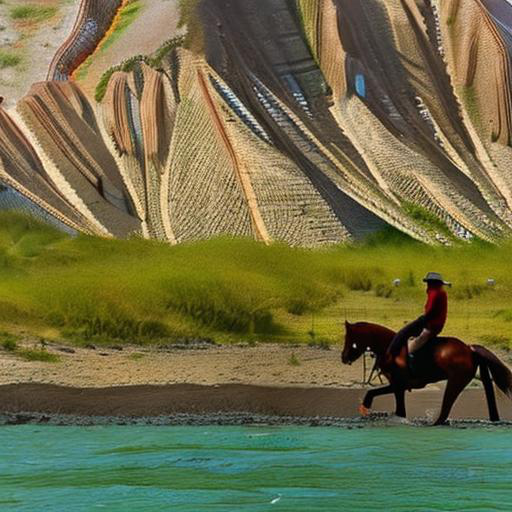

In [17]:
new_image